In [16]:
import os
import json
import time
import pinecone 
import pandas as pd 
import matplotlib.pyplot as plt
from langchain.vectorstores import Pinecone
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
%matplotlib inline

In [8]:
# Eval set
with open('eval_set.json', 'r') as f:
    full_qa_set = json.load(f)

# Pinecone IX of Ferris Episodes 
pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY'),  
    environment="us-east1-gcp"  
)
index_name = "ferris-gpt"
embeddings = OpenAIEmbeddings()
p = Pinecone.from_existing_index(index_name=index_name,embedding=embeddings)

Examine Retriever (https://blog.langchain.dev/retrieval/) vs VectorDBQA - 

* Both enable Retrieval Augmented Generation: system "retrieves" any documents, passes those documents (along with the original question) to the language model for a "generation" step
* Semantic search based on embedding similarity is common method for retrieval
* But broader support for features such as metadata filters prior to retrieval and different query methods are desired
* Also retrivers can be made outside of Langchain (OAI)
* VectorDBQA was limiteing, so `Retriever` has been released: get_relevant_documents: `VectorDBQA` is now `RetrievalQA`
* We purposefully enforce `query: str` as the only argument. For all other parameters - including metadata filtering - this should be stored as parameters on the retriever itself.

In [12]:
# Chains
from langchain.chains import VectorDBQA
VectorDBQA_chain = VectorDBQA.from_chain_type(llm=ChatOpenAI(temperature=0), 
                                       chain_type = "stuff", 
                                       vectorstore = p, 
                                       input_key = "question")

from langchain.chains import RetrievalQA
RetrievalQA_chain = RetrievalQA.from_chain_type(llm=ChatOpenAI(temperature=0), 
                                 chain_type="stuff", 
                                 retriever=p.as_retriever(),
                                 input_key = "question")

from langchain.evaluation.qa import QAEvalChain
eval_chain = QAEvalChain.from_llm(llm=ChatOpenAI(temperature=0))

/Users/31treehaus/opt/anaconda3/envs/ml/lib/python3.9/site-packages/langchain/chains/retrieval_qa/base.py:152: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [17]:
def run_eval(chain):

    predictions = []
    predicted_dataset = []

    for data in full_qa_set:
        start_time = time.time()
        new_data = {"question": data["question"],"answer": data["answer"]}
        predictions.append(chain(new_data))
        predicted_dataset.append(new_data)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time} seconds")
        print("--------")

    return predictions,predicted_dataset

predictions_list = []
scores_list = []

# Eval on two chains 
for chain in [VectorDBQA_chain,RetrievalQA_chain]:
    
    predictions,predicted_dataset=run_eval(chain)
    predictions_list.append(predictions)
    graded_outputs = eval_chain.evaluate(predicted_dataset, predictions, question_key="question", prediction_key="result")
    scores_list.append(graded_outputs)

Elapsed time: 3.908997058868408 seconds
--------
Elapsed time: 2.448621988296509 seconds
--------
Elapsed time: 6.14391303062439 seconds
--------
Elapsed time: 1.980428695678711 seconds
--------
Elapsed time: 1.9095370769500732 seconds
--------
Elapsed time: 5.601657867431641 seconds
--------
Elapsed time: 5.664294958114624 seconds
--------
Elapsed time: 2.701195001602173 seconds
--------
Elapsed time: 2.6222739219665527 seconds
--------
Elapsed time: 6.4196717739105225 seconds
--------
Elapsed time: 1.9807112216949463 seconds
--------
Elapsed time: 3.889810085296631 seconds
--------
Elapsed time: 7.374087810516357 seconds
--------
Elapsed time: 3.2770450115203857 seconds
--------
Elapsed time: 6.338855028152466 seconds
--------
Elapsed time: 1.8075931072235107 seconds
--------
Elapsed time: 2.3010520935058594 seconds
--------
Elapsed time: 2.0391552448272705 seconds
--------
Elapsed time: 2.8818678855895996 seconds
--------
Elapsed time: 1.8285009860992432 seconds
--------
Elapsed tim

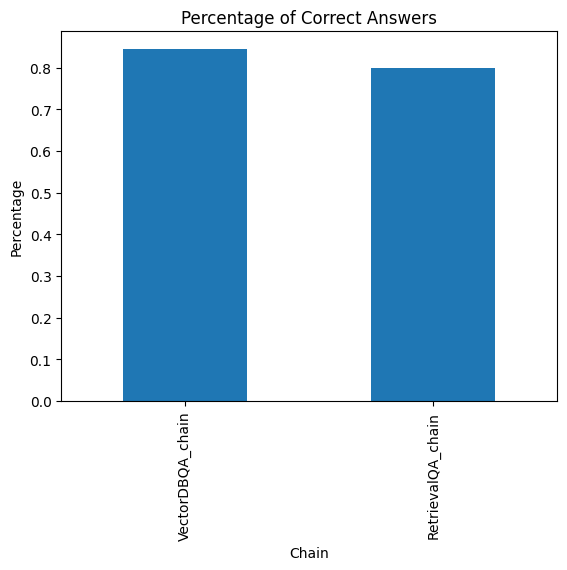

In [19]:
# Results
stor=pd.DataFrame()

for i,chunk_size in enumerate(["VectorDBQA_chain","RetrievalQA_chain"]):
    d=scores_list[i]
    incorrect_counts = []
    for dictionary in d:
        if dictionary['text'] == 'INCORRECT':
            incorrect_counts.append(1)
        else:
            incorrect_counts.append(0)
    stor.loc[chunk_size,'num_incorrect']=sum(incorrect_counts)

stor['pct_incorrect'] = stor['num_incorrect']  / len(full_qa_set)
stor['pct_correct'] = 1 - stor['pct_incorrect']
stor['pct_correct'].plot(kind='bar')
plt.title('Percentage of Correct Answers')
plt.xlabel('Chain')
plt.ylabel('Percentage')
plt.show()

`N = 3` eval rounds:
* `VectorDBQA_chain`: 84%, 80%, 82%
* `RetrievalQA_chain`: 80%, 73%, 76%